# Variational AutoEncoder with MNIT digits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Sampling layer

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Create Variational Autoencoder Model

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train VAE

In [7]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 123s 221ms/step - loss: 165.6452 - reconstruction_loss: 158.4310 - kl_loss: 5.0102
Epoch 2/10
547/547 [==============================] - 143s 262ms/step - loss: 159.7844 - reconstruction_loss: 153.5777 - kl_loss: 5.3766
Epoch 3/10
547/547 [==============================] - 125s 228ms/step - loss: 157.2704 - reconstruction_loss: 151.3038 - kl_loss: 5.5804
Epoch 4/10
547/547 [==============================] - 121s 222ms/step - loss: 156.0038 - reconstruction_loss: 149.8801 - kl_loss: 5.7150
Epoch 5/10
547/547 [==============================] - 141s 257ms/step - loss: 154.7009 - reconstruction_loss: 148.6688 - kl_loss: 5.8120
Epoch 6/10
547/547 [==============================] - 147s 269ms/step - loss: 153.7433 - reconstruction_loss: 147.7701 - kl_loss: 5.8709
Epoch 7/10
547/547 [==============================] - 171s 312ms/step - loss: 153.1134 - reconstruction_loss: 147.0010 - kl_loss: 5.9557
Epoch 8/10
547/547 [=====================

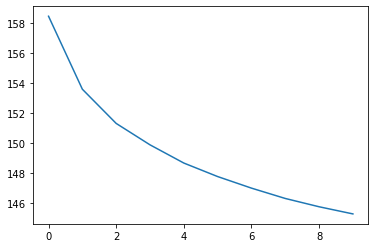

In [147]:
plt.plot(vae.history.history['reconstruction_loss']);

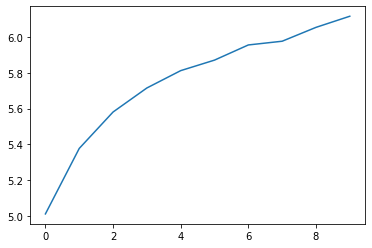

In [148]:
plt.plot(vae.history.history['kl_loss']);

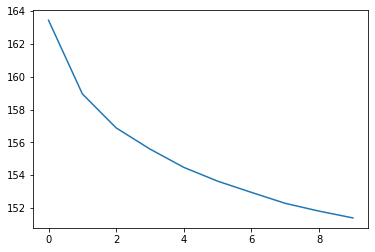

In [149]:
plt.plot(vae.history.history['loss']);

In [137]:
# Save model
vae.save_weights("models/keras_mnist")

In [142]:
# Loading model example
# vae_test = VAE(encoder, decoder)
# vae_test.load_weights("models/keras_mnist")
# generate_images(vae_test, 10, 28)

## Sample data predictions

In [127]:
def generate_images(
	model:keras.Model, n:int, img_size:int, 
	scale:float=1.0, show_fig:bool=True) -> np.ndarray:
	"""Generate and plot n images from the model(VAE), sampled by a Gaussian distribution.

	Parameters:
		model (keras.Model): The model to use for generation.
		n (int): The number of images to generate.
		img_size (int): The length of the predicted images, assuming it have a square format.
		scale (float): The scale of the latent space to sample from. Higher values will result in more noise, 
		and lower will show more similar images.
		show_fig (bool): Whether to show the figure or not.
	
	Returns:
		np.ndarray: A tensor representation of the generated images.
	"""

	# Sample from the latent space
	latent_dim = 2
	z = np.random.normal(size=(n, latent_dim)) * scale

	# Decode the samples
	predictions = model.decoder.predict(z)

	# Rescale the images to the original scale
	predictions = (predictions * 255).astype("uint8")

	# Plot the images
	if show_fig:
		fig = plt.figure(figsize=(10, 10))
		for i in range(n):
			ax = fig.add_subplot(10, 10, i + 1)
			plt.imshow(predictions[i, :, :, 0], cmap="gray")
			plt.axis("off")
		plt.show()

	# Return the predictions
	return predictions

1/1 [==============================] - 0s 41ms/step


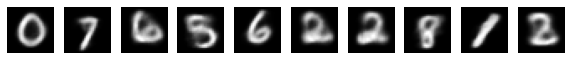

(10, 28, 28, 1)

In [128]:
_pred = generate_images(vae, 10, 28, 1)
_pred.shape

## Display grid of sample digits

In [134]:
def generate_images_from_grid(model, n, img_size, scale=1.0, sample:str='gaussian') -> plt.figure:
	"""Generate and plot n images from the model, sampled by a Gaussian distribution.

	Parameters:
		model (keras.Model): The model to use for generation.
		n (int): The number of images to generate.
		img_size (int): The length of the predicted images, assuming it have a square format.
		scale (float): The scale of the latent space to sample from. Higher values will result in more noise, 
		and lower will show more similar images.
		sample (str): The type of sampling to use. Can be 'gaussian' or 'grid'.
	
	Returns:
		A matplotlib figure containing the generated images.
	"""

	# Linearly spaced coordinates corresponding to the 2D plot of digit classes in the latent space
	grid_x = np.linspace(-scale, scale, n)
	grid_y = np.linspace(-scale, scale, n)[::-1]
	grid_x, grid_y = np.meshgrid(grid_x, grid_y)
	grid_x = grid_x.reshape(-1, 1)
	grid_y = grid_y.reshape(-1, 1)

	# Sample from the linear latent space
	if sample=='linear':
		z = np.hstack([grid_x, grid_y])
	# Sample from the Gaussian latent space
	elif sample=='gaussian':
		z = np.random.normal(size=((n**2), 2)) * scale
	else:
		raise ValueError(f"Invalid sample type: {sample}. Select 'linear' or 'gaussian'.")

	# Generate images from the grid sample values
	predictions = vae.decoder.predict(z)
	
	#predictions = (predictions * 255).astype("uint8")

	# Configure plot
	fig = plt.figure(figsize=(12, 12))
	# Compute coordinates and labels for the plot
	start_range = img_size // 2
	end_range = (n**2) * img_size + start_range
	pixel_range = np.arange(start_range, end_range, img_size)[:n:]
	sample_range_x = np.round(grid_x, 1)[:n:].T[0]
	sample_range_y = np.round(grid_y, 1)[::n].T[0]
	plt.xticks(pixel_range, sample_range_x)
	plt.yticks(pixel_range, sample_range_y)
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")

	# Display image
	plt.imshow(
		predictions.reshape(
			n, n, img_size, img_size
			).transpose(0, 2, 1, 3
			).reshape(n*img_size, n*img_size), 
		cmap='gray')

	return fig

4/4 [==============================] - 0s 20ms/step


/var/folders/_m/3m0bcc4n6h73gny0bt6_g4x80000gn/T/ipykernel_47316/1882635849.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  generate_images_from_grid(vae, 10, 28, 1, 'gaussian').show()


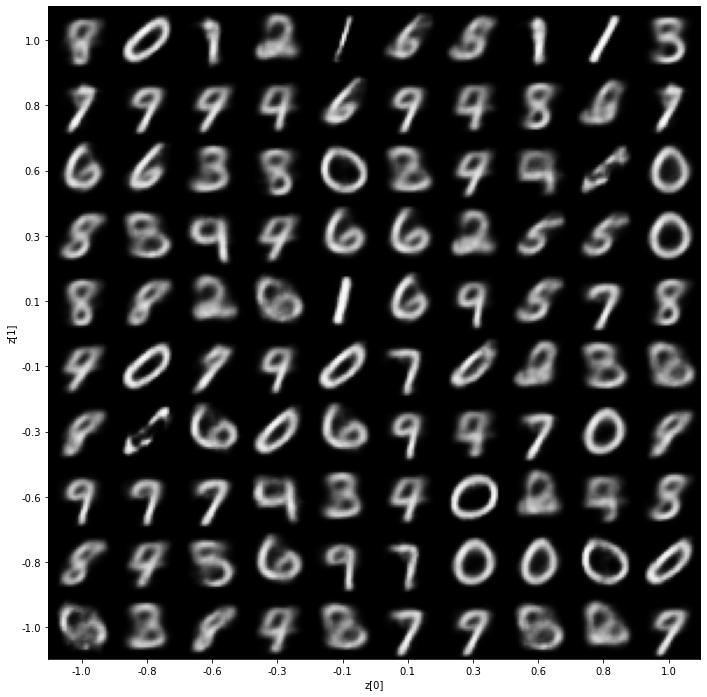

In [141]:
generate_images_from_grid(vae, 10, 28, 1, 'gaussian').show()

## Display latent space clusters difference between digit classesx

1875/1875 [==============================] - 16s 8ms/step


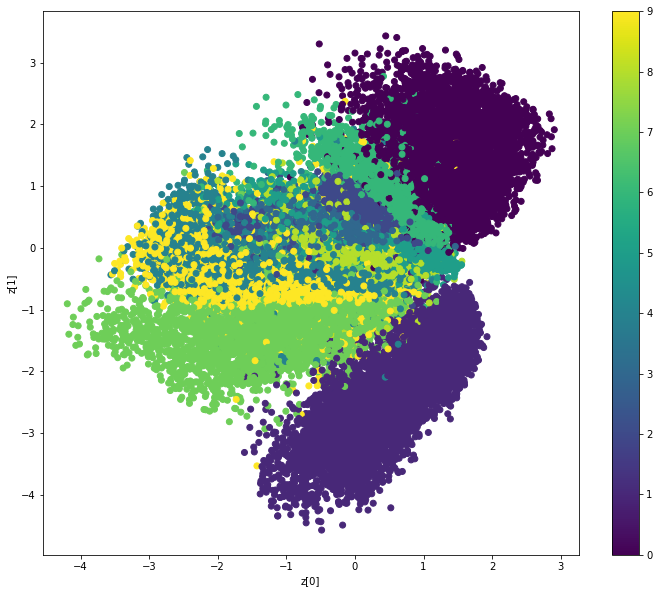

In [9]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)